In [6]:
import pysam
import pandas as pd
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading the file and appying transformations

In [7]:
sam_path = "data/rd/SRR.sam"

In [8]:
len_chr={}
with open(sam_path, 'r') as f:
    for line in f:
        l = line.replace('\n', '').split('\t')
        sn = l[1].replace('SN:', '')
        ln = l[2].replace('LN:', '')
        len_chr[sn] = ln
        if line[:1] == '@':
            pass
        else:
            break

In [9]:
SF = pysam.Samfile(sam_path, "rb")

## Creation of dataframe with genome information

In [10]:
sam_list = []
for sam in SF.fetch():
    sam_list.append([SF.getrname(sam.rname), sam.qname, sam.flag, sam.pos, sam.cigar, sam.seq])
    
SF.close()

df_sam = pd.DataFrame(sam_list, columns=['rname', 'qname', 'flag', 'pos', 'cigar', 'seq'])
df_sam['ln'] = df_sam['rname'].apply(lambda x: len_chr[x] if x in len_chr else np.nan)
df_sam = df_sam[df_sam['ln'].notna()]

df_sam['ln'] = df_sam['ln'].astype(int)

## Processing the SAM file

In [11]:
# Generate unsorted BAM file
pysam.samtools.view("-b", f"-odata/rd/SRR_unsorted.bam", sam_path, catch_stdout=False)

In [12]:
pysam.sort("data/rd/SRR_unsorted.bam", "-o", "data/rd/SRR.bam");

In [13]:
# Generate index for BAM file
pysam.index("data/rd/SRR.bam");

In [14]:
BF = pysam.AlignmentFile("data/rd/SRR.bam", "rb")

## Getting the number of reads for rach position

In [15]:
signal = np.zeros(df_sam['pos'].max()) 

for pos in BF.pileup():
    signal[pos.reference_pos] = pos.n

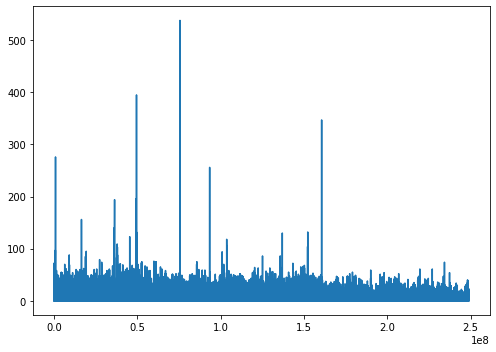

In [17]:
plt.figure(figsize=(7,5))
plt.plot(signal)
plt.tight_layout()
plt.show()

### Averaging over 100bp

In [18]:
sig_ln = signal.shape[0]

signal_avg_100 = signal[:sig_ln-sig_ln%100].reshape(-1, 100).mean(1)

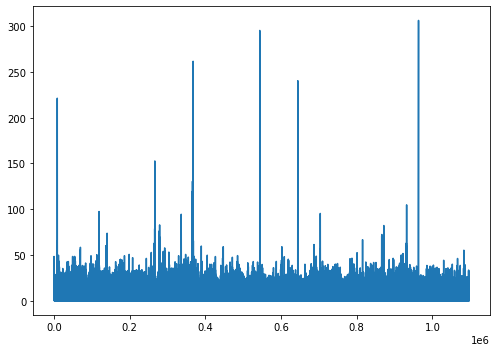

In [27]:
plt.figure(figsize=(7,5))
plt.plot(signal_avg_100)
plt.tight_layout()
plt.savefig('bined_signal.png', bbox_inches='tight')

### Creationf of hist of AVG RD

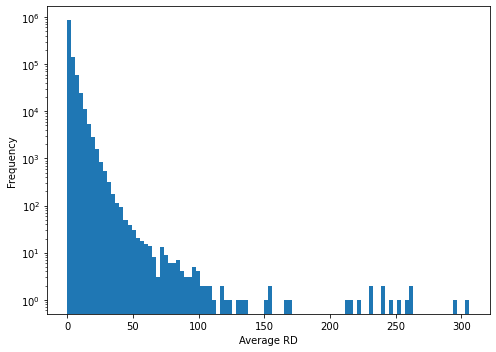

In [28]:
plt.figure(figsize=(7,5))
plt.hist(signal_avg_100, 100)
plt.yscale('log')
plt.xlabel('Average RD')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('hist_signal.png', bbox_inches='tight')

In [30]:
# plt.plot(signal_avg_100[:-1] - signal_avg_100[1:], signal_avg_100[1:] - signal_avg_100[:-1], '.')
# plt.show()

In [31]:
BF.close()

# Straightforward approach - trying to visualize the RD
(not very efficient)

In [32]:
df_chr = df_sam[df_sam['rname']=='chrY']

max_gene = df_chr['pos'].max() + df_chr['ln'].max()

chr_genom_reads = np.zeros(shape=(max_gene,) )

for pos, ln in tqdm(zip(
        df_chr['pos'].values, 
        df_chr['ln'].values),
            total=df_chr.shape[0], position=0, leave=True):
    
    chr_genom_reads[pos:pos+ln] += 1
    
chr_ln = chr_genom_reads.shape[0]

chr_avg_100 = chr_genom_reads[:chr_ln-chr_ln%100].reshape(-1, 100).mean(1)

100%|███████████████████████████████████████| 2771/2771 [01:44<00:00, 26.47it/s]


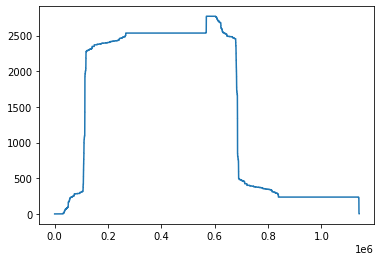

In [33]:
plt.step( range(chr_avg_100.shape[0]), chr_avg_100)
plt.show()